In [7]:
from math import gamma

import scipy
import numpy as np
import scipy.constants as constants
import math
import matplotlib.pyplot as plt

m = 4e-13
temp = 273
K = .0002
r = 2.7e-6
eta = .36e-3
rho_f = 789

times = np.logspace(-6, -2, 60)
zeros = np.zeros(len(times))


def compute_roots(m, K, r, eta, rho_f):
    t_f = (rho_f * r ** 2) / eta
    t_p = m / (6 * np.pi * r * eta)
    a = 1
    b = -6*math.pi*r**2*np.sqrt(rho_f*eta)/m
    c = 6*math.pi*r*eta/m
    d = 0
    e = K/m

    coeffs = [a, b, c, d, e]
    return np.roots(coeffs)

roots_ = compute_roots(m, K, r, eta, rho_f)


In [8]:
def hydro_msd(t, roots):
    return 2*constants.k*temp*c_inverse_form(t, roots)

# NEW AND CORRECTED CODE

def a_inverse_form(t, roots):
    return np.real((1/m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def b_inverse_form(t, roots):
    return np.real((1/m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def c_inverse_form(t, roots):
    a = roots[0]
    b = roots[1]
    c = roots[2]
    d = roots[3]

    m_over_k = 1/(a*b*c*d)

    ret = np.real((1/m) * sum(
        (scipy.special.erfcx(z * np.sqrt(t))) /
        (z*(np.prod([z - z_j for z_j in roots if z != z_j]))) for z in roots))

    return ret + m_over_k/m

def s_half_b_inverse_form(t, roots):
    return np.real((-1/m) * sum(
        (z**2 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def s_minus_half_b_inverse_form(t, roots):
     return np.real((-1/m) * sum(
        (scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def ensemble_r_term(t1, t2, m, K, roots):
    return np.real((constants.k*temp)*(c_inverse_form(t1, roots) + c_inverse_form(t2, roots) - c_inverse_form(np.abs(t2-t1), roots) - m*b_inverse_form(t1, roots)*b_inverse_form(t2, roots) - K*c_inverse_form(t1, roots)*c_inverse_form(t2, roots)))

def e_and_f(t, mass, radius, rho, eta, x0, v0, roots):
    gamma = 6*np.pi*radius*eta
    z = 6*radius**2*np.pi*np.sqrt(rho*eta)
    return mass*x0*a_inverse_form(t, roots) + mass*v0*b_inverse_form(t, roots) + gamma*x0*b_inverse_form(t, roots) + z*x0*s_half_b_inverse_form(t, roots) + z*v0*s_minus_half_b_inverse_form(t, roots)

def x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return e_and_f(t1, m, radius, rho_f, eta, x0, v0, roots_)*e_and_f(t2, m, radius, rho_f, eta, x0, v0, roots_) + ensemble_r_term(t1,t2, m, K, roots_)

def full_hydro_msd(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return x_t1_x_t2(t1, t1, m, K, radius, eta, rho_f, x0, v0) + x_t1_x_t2(t2, t2, m, K, radius, eta, rho_f, x0, v0) - 2 * x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0)

stationairy = hydro_msd(times, roots_)


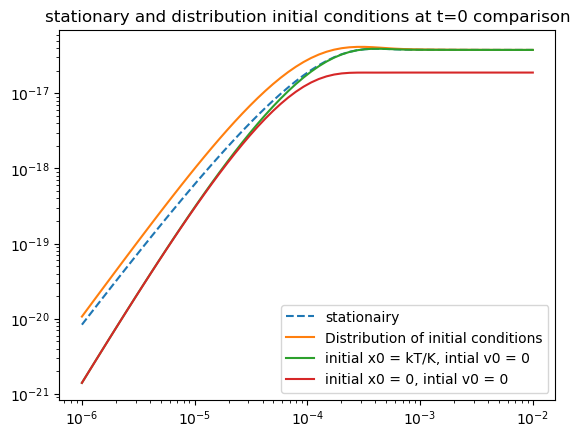

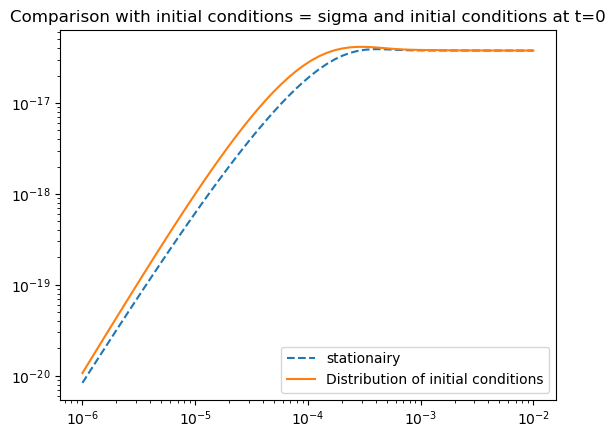

In [15]:
# Sample from a normal distribution to get the msd for different x0, v0

mu = 0
sigma_v = np.sqrt(constants.k*temp/m)
sigma_x = np.sqrt(constants.k*temp/K)
num_samples = 1000

initial_conditions_v = np.random.normal(mu, sigma_v, num_samples)
initial_conditions_x = np.random.normal(mu, sigma_x, num_samples)

results = np.zeros((num_samples, len(times)))

for i in range(num_samples):
    results[i, :] = full_hydro_msd(0, times, m, K, r, eta, rho_f, initial_conditions_x[i], initial_conditions_v[i])

averaged_initial_msd = results.mean(axis=0)

ic_is_sigma = full_hydro_msd(0, times, m, K, r, eta, rho_f,  np.sqrt(constants.k*temp/K), 0)
zero_ic = full_hydro_msd(0, times, m, K, r, eta, rho_f,  0, 0)

plt.plot(times, stationairy, linestyle = 'dashed', label = "stationairy")
plt.plot(times, averaged_initial_msd, label = "Distribution of initial conditions")
plt.plot(times, ic_is_sigma, label = "initial x0 = kT/K, intial v0 = 0")
plt.plot(times, zero_ic, label = "initial x0 = 0, intial v0 = 0")
plt.title("stationary and distribution initial conditions at t=0 comparison")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.plot(times, stationairy, linestyle = 'dashed', label = "stationairy")
plt.plot(times, averaged_initial_msd, label = "Distribution of initial conditions")
plt.title("Comparison with initial conditions = sigma and initial conditions at t=0")
plt.legend()
plt.xscale('log')
plt.yscale('log')

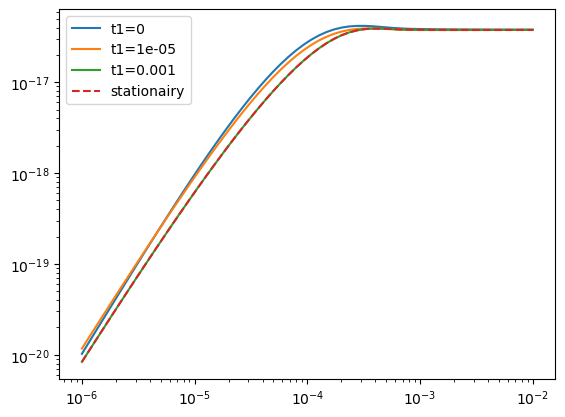

In [10]:
t1s = [0, 1e-5, 1e-3]
t1_comparisons = []
num_samples = 1000

for t1 in t1s:
    t1 = np.full(len(times), t1)
    t2 = t1 + times

    for i in range(num_samples):
      results[i, :] = full_hydro_msd(t1, t2, m, K, r, eta, rho_f, initial_conditions_x[i], initial_conditions_v[i])
    averaged_initial_msd = results.mean(axis=0)
    t1_comparisons.append(averaged_initial_msd)

for i in range(len(t1s)):
    plt.plot(times, t1_comparisons[i], label = f"t1={t1s[i]}")
plt.plot(times, stationairy, linestyle="dashed", label = "stationairy")
plt.xscale('log')
plt.yscale('log')
plt.legend()

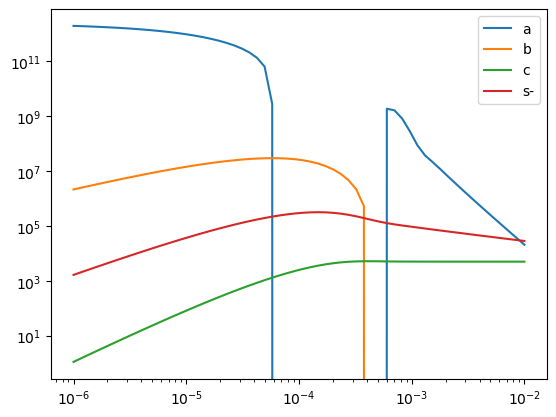

In [11]:
# GRAPH C

a_help = a_inverse_form(times, roots_)
c_help = c_inverse_form(times, roots_)
b_help = b_inverse_form(times, roots_)
s_minus = s_minus_half_b_inverse_form(times, roots_)

plt.plot(times, a_help, label = "a")
plt.plot(times, b_help, label = "b")
plt.plot(times, c_help, label = "c")
plt.plot(times, s_minus, label = "s-")
plt.xscale('log')
plt.yscale('log')
# plt.xlim(left=100)
# plt.ylim(bottom = 0, top=0.01)
plt.legend()

In [12]:

# THIS SECTION IS NOT POLISHED AND EXISTS TO TRY TO SOLVE THE DISCREPANCY BETWEEN THE STATIONARY CASE AND THE INITIAL CONDTION CASE WHICH EXISTS PRIMARILY DUE TO THE NOT RAMPING UP OF THE HISTORY TERM...

import numpy as np
from scipy.misc import derivative
# import matplotlib.pyplot as plt

# Analytic ACF (placeholder, replace with your form)
#
# def first_deriv_c_inverse_form(t, roots):
#     a = roots[0]
#     b = roots[1]
#     c = roots[2]
#     d = roots[3]
#     t = np.abs(t)  # Handle negative t
#     return -(1/((a - b)*(a - c)*(a - d)*np.sqrt(np.pi)*np.sqrt(t))) + (a*scipy.special.erfcx(a*np.sqrt(t)))/((a - b)*(a - c)*(a - d)) + (b/((a - b)*np.sqrt(np.pi)*np.sqrt(t))) - (b*(b - d))/((a - c)*(c - d)*np.sqrt(np.pi)*np.sqrt(t)) - (b**2*scipy.special.erfcx(b*np.sqrt(t)))/(a - b) + (b*c*(b - d)*scipy.special.erfcx(c*np.sqrt(t)))/((a - c)*(c - d)) - ((b - c)*(-(a*b*c*d/(np.sqrt(np.pi)*np.sqrt(t))) + a*b*c*d**2*scipy.special.erfcx(d*np.sqrt(t))))/(a*c*(a - d)*(c - d)*d*b*(b - c)*(b - d))

import numpy as np
# from scipy.special import erfcx
#
# def check_stability(value, term_name, t, roots):
#     """Check if a value is finite; print warning if not."""
#     if not np.isfinite(value):
#         print(f"Instability in {term_name} at t={t}, roots={roots}: {value}")
#         return False
#     return True
#
# import numpy as np
# from scipy.special import erfcx
#
# def check_stability_array(value, term_name, t, roots):
#     """Check array for non-finite values; return mask of valid elements."""
#     mask = np.isfinite(value)
#     if not np.all(mask):
#         invalid_idx = np.where(~mask)[0]
#         print(f"Instability in {term_name} at t={t[invalid_idx]}, roots={roots}: {value[invalid_idx]}")
#     return mask
#
# def second_deriv_c_inverse_form(t, roots):
#     a, b, c, d = roots
#     t = np.abs(t) + 1e-10  # Prevent zero division, works with arrays
#     sqrt_t = np.sqrt(t)
#     sqrt_pi = np.sqrt(np.pi)
#     t_3_2 = t * sqrt_t
#
#     # Precompute denominators (scalars)
#     denom_a = (a - b) * (a - c) * (a - d)
#     denom_b = b * (b - c) * (b - d)
#     denom_c = (a - c) * (c - d)
#     denom_d = a * c * (a - d) * (c - d) * d
#
#     # Check denominators (scalar, no array issue)
#     for name, val in [("denom_a", denom_a), ("denom_b", denom_b), ("denom_c", denom_c), ("denom_d", denom_d)]:
#         if np.abs(val) < 1e-10:
#             print(f"Warning: {name} near zero: {val}")
#
#     # Compute terms (vectorized)
#     terms = {}
#     terms["a1"] = 1 / (2 * denom_a * sqrt_pi * t_3_2)
#     terms["a2"] = -(a**2) / (denom_a * sqrt_pi * sqrt_t)
#     terms["a3"] = (a**3 * erfcx(a * sqrt_t)) / denom_a  # erfcx is vectorized
#
#     # B-term components
#     b_terms = {}
#     b_terms["b1"] = -b / (2 * (a - b) * sqrt_pi * t_3_2)
#     b_terms["b2"] = (b * (b - d)) / (2 * denom_c * sqrt_pi * t_3_2)
#     b_terms["b3"] = b**3 / ((a - b) * sqrt_pi * sqrt_t)
#     b_terms["b4"] = -(b * c**2 * (b - d)) / (denom_c * sqrt_pi * sqrt_t)
#     b_terms["b5"] = -(b**4 * erfcx(b * sqrt_t)) / (a - b)
#     b_terms["b6"] = (b * c**3 * (b - d) * erfcx(c * sqrt_t)) / denom_c
#
#     # Inner d-term
#     d_terms = {}
#     d_terms["d1"] = (a * b * c * d) / (2 * sqrt_pi * t_3_2)
#     d_terms["d2"] = -(a * b * c * d**3) / (sqrt_pi * sqrt_t)
#     d_terms["d3"] = a * b * c * d**4 * erfcx(d * sqrt_t)
#     d_inner = (b - c) * (d_terms["d1"] + d_terms["d2"] + d_terms["d3"]) / denom_d
#
#     # Combine b-terms
#     b_total = (b_terms["b1"] + b_terms["b2"] + b_terms["b3"] + b_terms["b4"] +
#                b_terms["b5"] + b_terms["b6"] - d_inner) / denom_b
#
#     # Stability masks
#     masks = {}
#     for name, val in terms.items():
#         masks[name] = check_stability_array(val, f"second_deriv term {name}", t, roots)
#     for name, val in b_terms.items():
#         masks[name] = check_stability_array(val, f"second_deriv b_term {name}", t, roots)
#     for name, val in d_terms.items():
#         masks[name] = check_stability_array(val, f"second_deriv d_term {name}", t, roots)
#     masks["b_total"] = check_stability_array(b_total, "second_deriv b_total", t, roots)
#
#     # Final sum
#     result = terms["a1"] + terms["a2"] + terms["a3"] + b_total
#     final_mask = check_stability_array(result, "second_deriv final", t, roots)
#
#     # Replace non-finite values with 0
#     result = np.where(final_mask, result, 0.0)
#     return np.real(result)

# def third_deriv_c_inverse(t, roots):
#     a, b, c, d = roots
#     t = np.abs(t) + 1e-10
#     sqrt_t = np.sqrt(t)
#     sqrt_pi = np.sqrt(np.pi)
#     t_3_2 = t * sqrt_t
#     t_5_2 = t**2 * sqrt_t
#
#     # Precompute denominators
#     denom_a = (a - b) * (a - c) * (a - d)
#     denom_b = b * (b - c) * (b - d)
#     denom_c = (a - c) * (c - d)
#     denom_d = a * c * (a - d) * (c - d) * d
#
#     # Check denominators
#     for name, val in [("denom_a", denom_a), ("denom_b", denom_b), ("denom_c", denom_c), ("denom_d", denom_d)]:
#         if np.abs(val) < 1e-10:
#             print(f"Warning: {name} near zero: {val}")
#
#     # Compute terms
#     terms = {}
#     terms["a1"] = -3 / (4 * denom_a * sqrt_pi * t_5_2)
#     terms["a2"] = (a**2) / (2 * denom_a * sqrt_pi * t_3_2)
#     terms["a3"] = -(a**4) / (denom_a * sqrt_pi * sqrt_t)
#     terms["a4"] = (a**5 * erfcx(a * sqrt_t)) / denom_a
#
#     # B-term components
#     b_terms = {}
#     b_terms["b1"] = (3 * b) / (4 * (a - b) * sqrt_pi * t_5_2)
#     b_terms["b2"] = -(3 * b * (b - d)) / (4 * denom_c * sqrt_pi * t_5_2)
#     b_terms["b3"] = -(b**3) / (2 * (a - b) * sqrt_pi * t_3_2)
#     b_terms["b4"] = (b * c**2 * (b - d)) / (2 * denom_c * sqrt_pi * t_3_2)
#     b_terms["b5"] = (b**5) / ((a - b) * sqrt_pi * sqrt_t)
#     b_terms["b6"] = -(b * c**4 * (b - d)) / (denom_c * sqrt_pi * sqrt_t)
#     b_terms["b7"] = -(b**6 * erfcx(b * sqrt_t)) / (a - b)
#     b_terms["b8"] = (b * c**5 * (b - d) * erfcx(c * sqrt_t)) / denom_c
#
#     # Inner d-term
#     d_terms = {}
#     d_terms["d1"] = -(3 * a * b * c * d) / (4 * sqrt_pi * t_5_2)
#     d_terms["d2"] = (a * b * c * d**3) / (2 * sqrt_pi * t_3_2)
#     d_terms["d3"] = -(a * b * c * d**5) / (sqrt_pi * sqrt_t)
#     d_terms["d4"] = (a * b * c * d**6 * erfcx(d * sqrt_t))
#     d_inner = (b - c) * (d_terms["d1"] + d_terms["d2"] + d_terms["d3"] + d_terms["d4"]) / denom_d
#
#     # Combine b-terms
#     b_total = (b_terms["b1"] + b_terms["b2"] + b_terms["b3"] + b_terms["b4"] +
#                b_terms["b5"] + b_terms["b6"] + b_terms["b7"] + b_terms["b8"] - d_inner) / denom_b
#
#     # Stability masks
#     masks = {}
#     for name, val in terms.items():
#         masks[name] = check_stability_array(val, f"third_deriv term {name}", t, roots)
#     for name, val in b_terms.items():
#         masks[name] = check_stability_array(val, f"third_deriv b_term {name}", t, roots)
#     for name, val in d_terms.items():
#         masks[name] = check_stability_array(val, f"third_deriv d_term {name}", t, roots)
#     masks["b_total"] = check_stability_array(b_total, "third_deriv b_total", t, roots)
#
#     # Final sum
#     result = terms["a1"] + terms["a2"] + terms["a3"] + terms["a4"] + b_total
#     final_mask = check_stability_array(result, "third_deriv final", t, roots)
#
#     # Replace non-finite values with 0
#     result = np.where(final_mask, result, 0.0)
#     return np.real(result)
# #
# # # Test with array
# # roots = [-0.01, -0.02, -0.03, -0.04]
# # t_values = np.array([0.001, 0.01, 0.1, -0.1, 1.0])
# # second = second_deriv_c_inverse_form(t_values, roots)
# # third = third_deriv_c_inverse(t_values, roots)
# #
# # print("Second derivative results:")
# # for t, val in zip(t_values, second):
# #     print(f"t = {t:.4f}, second_deriv = {val:.6e}")
# #
# # print("\nThird derivative results:")
# # for t, val in zip(t_values, third):
# #     print(f"t = {t:.4f}, third_deriv = {val:.6e}")
#
# def second_deriv_c_inverse_formold(t, roots):
#     a = roots[0]
#     b = roots[1]
#     c = roots[2]
#     d = roots[3]
#         # Precompute square roots and common terms
#     sqrt_t = np.sqrt(t)
#     sqrt_pi = np.sqrt(np.pi)
#     t_3_2 = t * sqrt_t
#
#     # print(sqrt_t, sqrt_pi, t_3_2)
#     #
#     # print("2 tau is " + str(t))
#     return np.real(
#         (1/(2*(a-b)*(a-c)*(a-d)*sqrt_pi*t_3_2)
#         - (a**2)/((a-b)*(a-c)*(a-d)*sqrt_pi*sqrt_t)
#         + (a**3*scipy.special.erfcx(a*sqrt_t)*np.exp(-(a*sqrt_t)**2))/((a-b)*(a-c)*(a-d))
#         + (
#             (
#                 -b/(2*(a-b)*sqrt_pi*t_3_2)
#                 + (b*(b-d))/(2*(a-c)*(c-d)*sqrt_pi*t_3_2)
#                 + b**3/((a-b)*sqrt_pi*sqrt_t)
#                 - (b*c**2*(b-d))/((a-c)*(c-d)*sqrt_pi*sqrt_t)
#                 - (b**4*scipy.special.erfcx(b*sqrt_t)*np.exp(-(b*sqrt_t)**2))/(a-b)
#                 + (b*c**3*(b-d)*scipy.special.erfcx(c*sqrt_t)*np.exp(-(c*sqrt_t)**2))/((a-c)*(c-d))
#                 - (
#                     (b-c)*(
#                         (a*b*c*d)/(2*sqrt_pi*t_3_2)
#                         - (a*b*c*d**3)/(sqrt_pi*sqrt_t)
#                         + a*b*c*d**4*scipy.special.erfcx(d*sqrt_t)*np.exp(-(d*sqrt_t)**2)
#                     )
#                 )/(a*c*(a-d)*(c-d)*d)
#             )
#             / (b*(b-c)*(b-d))
#         )
#     ))
#
# def third_deriv_c_inverseold(t, roots):
#     a, b, c, d = roots
#
#     # Precompute common terms
#     sqrt_t = np.sqrt(t)
#     sqrt_pi = np.sqrt(np.pi)
#     t_3_2 = t * sqrt_t
#     t_5_2 = t**2 * sqrt_t
#     # print("3 tau is " + str(t))
#     #
#     # print(sqrt_t, sqrt_pi, t_3_2, t_5_2)
#
#     return np.real(
#         - (3/(4*(a-b)*(a-c)*(a-d)*sqrt_pi*t_5_2))
#         + (a**2)/(2*(a-b)*(a-c)*(a-d)*sqrt_pi*t_3_2)
#         - (a**4)/((a-b)*(a-c)*(a-d)*sqrt_pi*sqrt_t)
#         + (a**5*scipy.special.erfcx(a*sqrt_t)*np.exp(-(a*sqrt_t)**2))/((a-b)*(a-c)*(a-d))
#         + (1/(b*(b-c)*(b-d))) * (
#             (3*b)/(4*(a-b)*sqrt_pi*t_5_2)
#             - (3*b*(b-d))/(4*(a-c)*(c-d)*sqrt_pi*t_5_2)
#             - (b**3)/(2*(a-b)*sqrt_pi*t_3_2)
#             + (b*c**2*(b-d))/(2*(a-c)*(c-d)*sqrt_pi*t_3_2)
#             + (b**5)/((a-b)*sqrt_pi*sqrt_t)
#             - (b*c**4*(b-d))/((a-c)*(c-d)*sqrt_pi*sqrt_t)
#             - (b**6*scipy.special.erfcx(b*sqrt_t)*np.exp(-(b*sqrt_t)**2))/(a-b)
#             + (b*c**5*(b-d)*scipy.special.erfcx(c*sqrt_t)*np.exp(-(c*sqrt_t)**2))/((a-c)*(c-d))
#             - ((b-c)/(a*c*(a-d)*(c-d)*d)) * (
#                 - (3*a*b*c*d)/(4*sqrt_pi*t_5_2)
#                 + (a*b*c*d**3)/(2*sqrt_pi*t_3_2)
#                 - (a*b*c*d**5)/(sqrt_pi*sqrt_t)
#                 + (a*b*c*d**6*scipy.special.erfcx(d*sqrt_t)*np.exp(-(d*sqrt_t)**2))
#             )
#         )
#     )
#
# def C_xx(tau):
#     tau = np.abs(tau)
#     return constants.k*temp*((1.0/K) - c_inverse_form(tau, roots_))
#
# # Numerical derivatives
# def d2_C_xx(tau, roots):
#     tau = np.abs(tau)
#     return -constants.k*temp*second_deriv_c_inverse_form(tau, roots)
#
# def d3_C_xx(tau, roots):
#     tau = np.abs(tau)
#     return -constants.k*temp*third_deriv_c_inverse(tau, roots)
#
#
# plt.plot(times, C_xx(times),  label="Cxx")
# # plt.plot(first_deriv_c_inverse_form(times, roots_), label="Cxx")
# plt.plot(times, second_deriv_c_inverse_form(times, roots_), label="d2Cxx")
# plt.plot(times, third_deriv_c_inverse(times, roots_), label="d3Cxx")
# plt.xscale('log')
# plt.yscale('log')
# plt.legend()
# plt.show()
#
# # Doob-conditioned mean acceleration
# def doob_x_ddot(tau, x0, v0, t=0):
#     """
#     Compute <x_ddot(tau)>_cond given x(t=0) = x0, x_dot(t=0) = v0
#     tau < 0, t = 0 is the conditioning point
#     """
#     if tau > 0:
#         raise ValueError("tau must be <= 0 for history term")
#
#     # Variances at t=0
#     x2 = np.sqrt(constants.k*temp/K)        # <x(0)^2>
#     v2 = np.sqrt(constants.k*temp/m)      # <v(0)^2> = -d^2/dt^2 C_xx(0)
#
#     # Correlations
#     # <x_ddot(tau) x(0)> = -d^2/dtau^2 C_xx(tau) for tau < 0
#     corr_x_ddot_x = -d2_C_xx(tau, roots_)
#     # <x_ddot(tau) v(0)> = d^3/dtau^3 C_xx(tau)
#     corr_x_ddot_v = d3_C_xx(tau, roots_)
#
#     # Conditional mean
#     return (corr_x_ddot_x / x2) * x0 + (corr_x_ddot_v / v2) * v0
#
# # Test function
# def test_doob_x_ddot(x0, v0, t1):
#     tau_values = np.linspace(-t1, -.5, 100)
#     x_ddot_values = [doob_x_ddot(tau, x0, v0) for tau in tau_values]
#
#     # Plot
#     plt.plot(tau_values, x_ddot_values, label=f'x0={x0}, v0={v0}')
#     plt.xlabel('tau')
#     plt.ylabel('<x_ddot(tau)>_cond')
#     plt.yscale('log')
#     plt.title('Conditional Mean Acceleration')
#     plt.legend()
#     plt.grid(True)
#     plt.show()
#
#     # Print sample values
#     print(f"Testing with x0={x0}, v0={v0}:")
#     for tau, x_ddot in zip(tau_values[::20], x_ddot_values[::20]):
#         print(f"tau = {tau:.3f}, <x_ddot(tau)>_cond = {x_ddot:.6f}")
#
# # Run tests
# test_cases = [
#     (0, np.sqrt(constants.k*temp/m)*100) # Negative both
# ]
#
# for x0, v0 in test_cases:
#     test_doob_x_ddot(x0, v0, .0001)